# Assignment2
- Student: Zhulin Lyu
- Student ID: 24516605

## Part 1 – Voting Classifier
### Task 1. Load the dataset 

In [1]:
# Setup Evironment
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import scatter_matrix

%matplotlib inline
plt.rcParams['font.size'] = 12
sns.set_style("whitegrid")
print("Environment setup complete")

# read data
columns = ['ID', 'Diagnosis', 
           'radius_mean', 'texture_mean', 'perimeter_mean', 'area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean', 'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean',
           'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se', 'compactness_se', 'concavity_se', 'concave points_se', 'symmetry_se', 'fractal_dimension_se',
           'radius_worst', 'texture_worst', 'perimeter_worst', 'area_worst', 'smoothness_worst', 'compactness_worst', 'concavity_worst', 'concave points_worst', 'symmetry_worst', 'fractal_dimension_worst']

data = pd.read_csv('wdbc.data', names=columns)
print("Load the dataset success.")

Environment setup complete
Load the dataset success.


In [2]:
# Check for missing value
missing_values = data.isnull().sum()
print("The number of missing values:\n", missing_values)

#Count the number of occurrences of each diagnosis type
diagnosis_count = data['Diagnosis'].value_counts()
print("\nNumbers of diffirent diagnosis type:\n", diagnosis_count)

# Check if the dataset is imbalanced (if greater than 10, it's considered imbalanced)
is_imbalanced = diagnosis_count.max() / diagnosis_count.min() > 10
print("\nIs the data imbalanced: ", is_imbalanced)

The number of missing values:
 ID                         0
Diagnosis                  0
radius_mean                0
texture_mean               0
perimeter_mean             0
area_mean                  0
smoothness_mean            0
compactness_mean           0
concavity_mean             0
concave points_mean        0
symmetry_mean              0
fractal_dimension_mean     0
radius_se                  0
texture_se                 0
perimeter_se               0
area_se                    0
smoothness_se              0
compactness_se             0
concavity_se               0
concave points_se          0
symmetry_se                0
fractal_dimension_se       0
radius_worst               0
texture_worst              0
perimeter_worst            0
area_worst                 0
smoothness_worst           0
compactness_worst          0
concavity_worst            0
concave points_worst       0
symmetry_worst             0
fractal_dimension_worst    0
dtype: int64

Numbers of diffirent diagno

There is a **multicollinearity issue** in the data, which cannot be easily resolved be deleting features.
So, I choose do not delete any columns.

### Task 2. Split the dataset into a training and testing set.

In [3]:
from sklearn.model_selection import train_test_split

X = data.drop(columns=["ID"]).drop(columns=["Diagnosis"])
y = data['Diagnosis'].map({'B': 0, 'M': 1}) #1 is malignancy（M）

# 8/2 split, need to stratify
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print("Split train set and test set success.")

Split train set and test set success.


### Task 3. Fit three base models 

In [4]:
# Logistic Regression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import numpy as np

pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('lr', LogisticRegression(
        solver='saga',
        max_iter=5000,
        random_state=42
    ))
])

param_grid = {
    'lr__C': [0.1, 1, 10],
    'lr__penalty': ['l1', 'l2']
}

log_clf = GridSearchCV(
    pipe,
    param_grid,
    cv=3,
    scoring='f1',
    n_jobs=-1
)

log_clf.fit(X_train, y_train)

print("Best params:", log_clf.best_params_)
print("Best CV F1:", log_clf.best_score_)


Best params: {'lr__C': 1, 'lr__penalty': 'l2'}
Best CV F1: 0.9640712140712141


In [5]:
# Random Forest
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
import numpy as np

rf = RandomForestClassifier(random_state=42)

param_dist = {
    'n_estimators': [100, 300, 500],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': [None, 'sqrt', 'log2'],
    'bootstrap': [True, False]
}

rf_clf = RandomizedSearchCV(
    rf,
    param_dist,
    n_iter=50,
    cv=3,
    scoring='f1',
    n_jobs=-1,
    random_state=42
)

rf_clf.fit(X_train, y_train)

print("Best params:\n", rf_clf.best_params_)
print("Best CV F1:", rf_clf.best_score_)


Best params:
 {'n_estimators': 300, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': 30, 'bootstrap': False}
Best CV F1: 0.9555871661134819


In [6]:
# Support Vector Machine
import numpy as np
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV


pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('svc', SVC(
        probability=True,   # must be True to support soft voting
        random_state=42
    ))
])

param_grid = [
    {
        'svc__kernel': ['linear'],
        'svc__C': np.logspace(-3, 3, 7)
    },
    {
        'svc__kernel': ['rbf', 'poly', 'sigmoid'],
        'svc__C': np.logspace(-3, 3, 7),
        'svc__gamma': np.logspace(-4, 1, 6)
    }
]

svm_clf = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    cv=5,
    scoring='f1',
    n_jobs=-1
)

svm_clf.fit(X_train, y_train)

print("Best SVM params:", svm_clf.best_params_)
print("Best CV F1:", svm_clf.best_score_)


Best SVM params: {'svc__C': 10.0, 'svc__gamma': 0.01, 'svc__kernel': 'rbf'}
Best CV F1: 0.9638875854839515


In [7]:
# Output the accuracy rate
from sklearn.metrics import accuracy_score, classification_report

best_lr = log_clf.best_estimator_
best_rf = rf_clf.best_estimator_
best_svm = svm_clf.best_estimator_

for name, model in [('Logistic Regression', best_lr),
                    ('Random Forest', best_rf),
                    ('SVM', best_svm)]:
    y_pred = model.predict(X_test)
    print(f"\n{name} accuracy: {accuracy_score(y_test, y_pred):.3f}")
    print(classification_report(y_test, y_pred))



Logistic Regression accuracy: 0.965
              precision    recall  f1-score   support

           0       0.96      0.99      0.97        72
           1       0.97      0.93      0.95        42

    accuracy                           0.96       114
   macro avg       0.97      0.96      0.96       114
weighted avg       0.97      0.96      0.96       114


Random Forest accuracy: 0.965
              precision    recall  f1-score   support

           0       0.95      1.00      0.97        72
           1       1.00      0.90      0.95        42

    accuracy                           0.96       114
   macro avg       0.97      0.95      0.96       114
weighted avg       0.97      0.96      0.96       114


SVM accuracy: 0.982
              precision    recall  f1-score   support

           0       0.97      1.00      0.99        72
           1       1.00      0.95      0.98        42

    accuracy                           0.98       114
   macro avg       0.99      0.98      

### Task 4. Create a Voting Classifier

In [8]:
from sklearn.ensemble import VotingClassifier

# Create Voting Classifier（soft voting）
voting_clf = VotingClassifier(
    estimators=[
        ('lr', best_lr),
        ('rf', best_rf),
        ('svm', best_svm)
    ],
    voting='soft'  # soft voting
)

# Add different weight to each models
    # SVM are better than Logistic and Random Forest, so give those two lower weight
voting_clf = VotingClassifier(
    estimators=[('lr', best_lr), ('rf', best_rf), ('svm', best_svm)],
    voting='soft',
    weights=[1, 1, 2]
)

# Train Voting Classifier
voting_clf.fit(X_train, y_train)

# Predict and output the accuracy rate
from sklearn.metrics import accuracy_score, classification_report

y_pred = voting_clf.predict(X_test)
print(f"Voting Classifier Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(classification_report(y_test, y_pred))


Voting Classifier Accuracy: 0.9825
              precision    recall  f1-score   support

           0       0.97      1.00      0.99        72
           1       1.00      0.95      0.98        42

    accuracy                           0.98       114
   macro avg       0.99      0.98      0.98       114
weighted avg       0.98      0.98      0.98       114



### Task 5. Evaluate the performance
#### (a) Create a table of precision, recall, and F1-scores for each model.

In [9]:
from sklearn.metrics import precision_score, recall_score, f1_score
import pandas as pd

models = {
    'Logistic Regression': best_lr,
    'Random Forest': best_rf,
    'SVM': best_svm,
    'Voting Classifier': voting_clf
}

results = []

for name, model in models.items():
    y_pred = model.predict(X_test)
    precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    results.append({
        'Model': name,
        'Precision': round(precision, 4),
        'Recall': round(recall, 4),
        'F1-Score': round(f1, 4)
    })

results_df = pd.DataFrame(results)
print(results_df)


                 Model  Precision  Recall  F1-Score
0  Logistic Regression     0.9652  0.9649    0.9647
1        Random Forest     0.9668  0.9649    0.9645
2                  SVM     0.9829  0.9825    0.9824
3    Voting Classifier     0.9829  0.9825    0.9824


#### (b) Display a confusion matrix for each model.

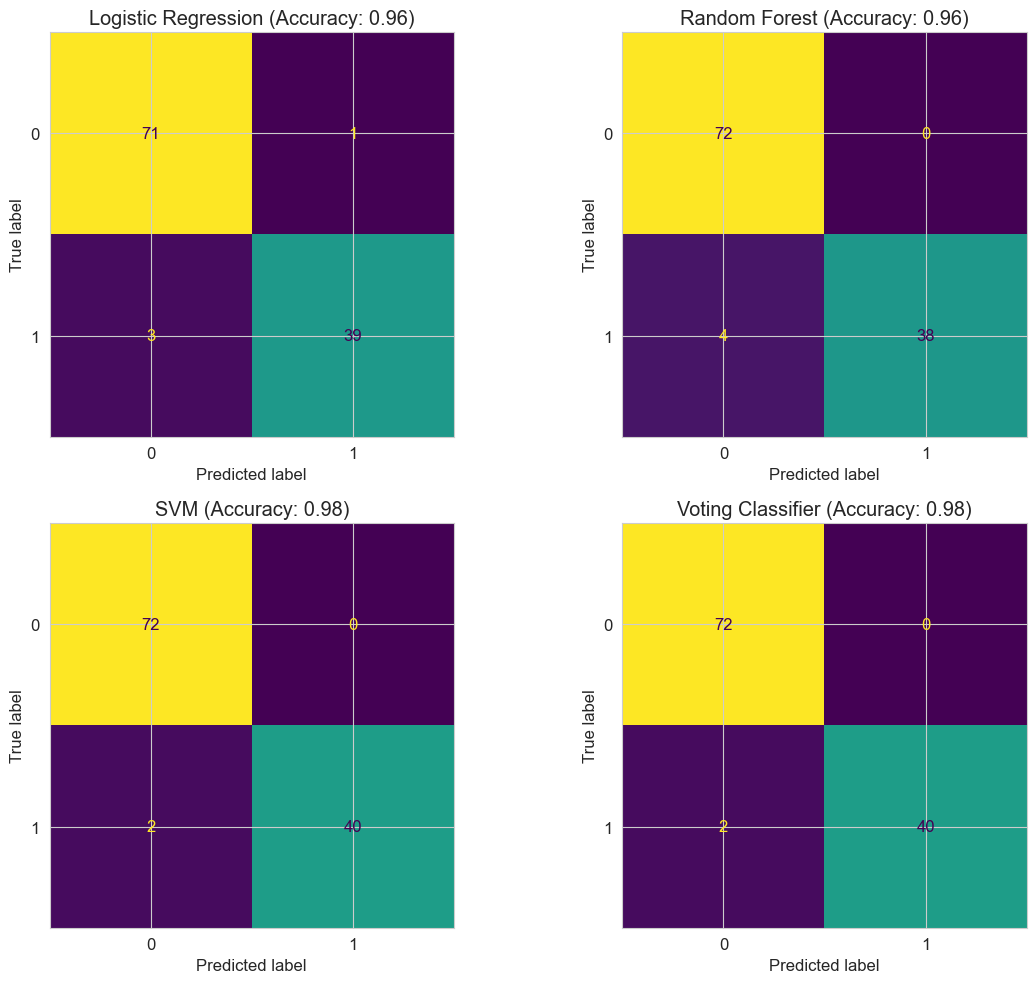

In [10]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 10))
for i, (name, model) in enumerate(models.items(), 1):
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    acc = accuracy_score(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    
    plt.subplot(2, 2, i)
    disp.plot(ax=plt.gca(), colorbar=False)
    plt.title(f"{name} (Accuracy: {acc:.2f})")

plt.tight_layout()
plt.show()


### Task 6. Comment on results 
#### (a) How do the models compare to each other? Which model performs best? Is this what you expected?

Looking at the summary, all four classifiers perform extremely well, but there are clear differences:

* **Logistic Regression** vs. **Random Forest**

  * LR: Precision 0.965 | Recall 0.965 | F1 0.965
  * RF: Precision 0.967 | Recall 0.965 | F1 0.965
  * The Random Forest edges out LR by a hair on precision (0.9668 vs. 0.9652), but their F1-scores are essentially identical.

* **SVM**

  * Precision 0.983 | Recall 0.983 | F1 0.982
  * SVM clearly leads the pack, improving both precision and recall by around 1.6 percentage points over LR/RF.

* **Voting Classifier** (soft‐voting of LR, RF, SVM)

  * Precision 0.983 | Recall 0.983 | F1 0.982
  * Matches the SVM exactly—no surprise, since SVM was already dominating and its votes carry the most weight in the soft‐voting ensemble.

**Which model performs best?**

* The **SVM** (and thus the **voting ensemble**) achieve the highest F1 (0.9824), making them the top performers.

**Was this expected?**

* Yes. On high-dimensional but relatively clean data, SVMs often excel at finding the optimal margin boundary, especially with balanced classes and an RBF or linear kernel tuned appropriately.
* The fact that the voting classifier doesn’t outperform the SVM suggests that SVM’s decisions were already so confident that combining with LR and RF didn’t add much new information.

In practice, I will choose the SVM (for simplicity) or the voting ensemble (for stability) as a final model.


#### (b) What are the advantages and disadvantages of using a voting classifier instead of just using one of the base models?

### Advantages

* **Robustness to individual weaknesses**
  By combining models that make different kinds of errors, a voting classifier can “cover” for one model’s blind spots. If one base learner misclassifies a particular sample but the others get it right, the ensemble still votes correctly.

* **Reduced variance**
  Ensembling tends to smooth out fluctuations that any single model might have from fold to fold or from small changes in the data, leading to more stable predictions overall.

* **Often better generalization**
  Even if none of the individual models dominates on every metric, their combined decision rule can edge out each one on average—especially when their errors are uncorrelated.

* **Simple to implement**
  A voting wrapper is conceptually and programmatically straightforward, and doesn’t require learning extra parameters (unlike stacking), so there’s minimal risk of overfitting the ensemble itself.

---

### Disadvantages

* **Higher computational cost**
  We need to train (and at inference time, predict with) all three models instead of just one. That slows both training and prediction.

* **Limited upside if one model already dominates**
  In my results, the SVM already achieves F1 ≈ 0.9824, and the voting classifier matches that exactly. When one base learner is substantially stronger, an unweighted vote may not improve performance.

* **Interpretability suffers**
  It’s harder to trace why the ensemble made a particular decision, since we have to inspect all base predictions rather than, say, a single logistic‐regression coefficient.

* **Maintenance complexity**
  I now have three separate pipelines (and hyperparameter grids) to keep in sync, debug, and potentially re-tune if the data shifts.

---

**In this case:**

* **Pros:** I match the SVM’s top performance but gain the safety net of ensemble stability.
* **Cons:** I pay the cost of three models in training/inference, yet see no F1 gain over the SVM.


##  Part 2 – Labeled Faces in the Wild

In [11]:
# Load the dataset
from sklearn.datasets import fetch_lfw_people
lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.5)
n_samples, h, w = lfw_people.images.shape
X = lfw_people.data
n_features = X.shape[1]
y = lfw_people.target
target_names = lfw_people.target_names
n_classes = target_names.shape[0]
print("Load the dataset success.")

Load the dataset success.


In [12]:
# Dataset info
lfw_people['DESCR'] 


".. _labeled_faces_in_the_wild_dataset:\n\nThe Labeled Faces in the Wild face recognition dataset\n------------------------------------------------------\n\nThis dataset is a collection of JPEG pictures of famous people collected\nover the internet, all details are available on the official website:\n\n    http://vis-www.cs.umass.edu/lfw/\n\nEach picture is centered on a single face. The typical task is called\nFace Verification: given a pair of two pictures, a binary classifier\nmust predict whether the two images are from the same person.\n\nAn alternative task, Face Recognition or Face Identification is:\ngiven the picture of the face of an unknown person, identify the name\nof the person by referring to a gallery of previously seen pictures of\nidentified persons.\n\nBoth Face Verification and Face Recognition are tasks that are typically\nperformed on the output of a model trained to perform Face Detection. The\nmost popular model for Face Detection is called Viola-Jones and is\ni

In [13]:
# Explore that if the data is balanced
import numpy as np

unique, counts = np.unique(y, return_counts=True)
for cls, cnt in zip(unique, counts):
    pct = cnt / counts.sum() * 100
    print(f"{target_names[cls]:20s}: {cnt:4d} samples, {pct:5.1f}%")

is_imbalanced = counts.max() / counts.min() > 10
print("\nIs the data imbalanced: ", is_imbalanced)


Ariel Sharon        :   77 samples,   6.0%
Colin Powell        :  236 samples,  18.3%
Donald Rumsfeld     :  121 samples,   9.4%
George W Bush       :  530 samples,  41.1%
Gerhard Schroeder   :  109 samples,   8.5%
Hugo Chavez         :   71 samples,   5.5%
Tony Blair          :  144 samples,  11.2%

Is the data imbalanced:  False


### Task 1. Briefly describe the dataset
#### (a) How many examples are there in the dataset? What do the examples represent?

In [14]:
# Number of examples
print(n_samples)

1288


**Representation of the examples**

Each example is a single grayscale face image (resized to half-scale) from the “Labeled Faces in the Wild” dataset. Concretely, each sample is a 2D array of pixel intensities (flattened into a feature vector) depicting one individual’s face, with the associated label indicating which person it is.

So each example represents one person’s face picture, with its pixels as features and its identity as the target.


#### (b) Describe the features of the dataset. What do they represent? How many features are there?

In [15]:
# Number of features
print(h, w)
print(n_features) # h*w

62 47
2914


**Describing dataset features**

Each feature is the intensity of one pixel in the flattened face image. After loading with

```python
lfw = fetch_lfw_people(min_faces_per_person=70, resize=0.5)
X = lfw.data
```

Each row of X corresponds to one face, and each column corresponds to one fixed (row, column) pixel location in that face. The value is the grayscale brightness of that pixel. Each pixel is stored as a real number (dtype `float32`), typically in the \[0, 255] range, where 0 means black and 255 means white.

#### (c) Describe the target of the dataset. How many classes are there?

In [16]:
# Number of classes
print(n_classes)

7


**The target of the dataset**

The target vector `y` encodes which person appears in each image. Each integer label corresponds to one of the individuals in the dataset (e.g., George W. Bush, Colin Powell, Tony Blair, etc.). In the filtered LFW subset (with `min_faces_per_person=70`), there are **7 distinct classes**—one for each of the seven celebrities who have at least 70 images. Internally, these classes are encoded as integers `0` through `6` in the array `y`.

### Task 2. Split the dataset into a training and testing set.

In [17]:
from sklearn.model_selection import train_test_split

# 8/2 split, need to stratify
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

### Task 3. Sample a random example for each class

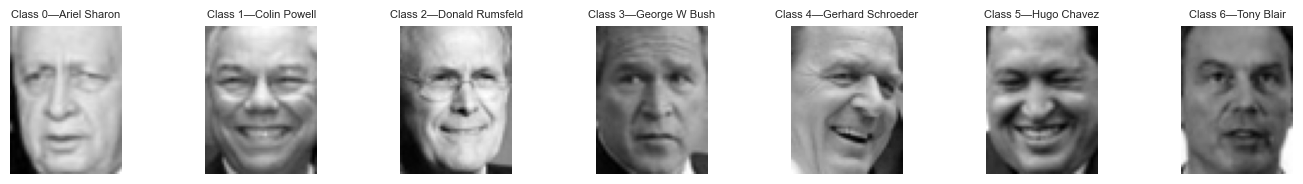

In [18]:
import numpy as np
import matplotlib.pyplot as plt

rng = np.random.default_rng(42)
sample_idxs = [rng.choice(np.where(y_train == cls)[0]) for cls in range(n_classes)]

fig, axes = plt.subplots(1, n_classes, figsize=(2*n_classes, 2))
for ax, idx in zip(axes, sample_idxs):
    img = X_train[idx].reshape(h, w)
    cls = y_train[idx]
    ax.imshow(img, cmap='gray')
    ax.set_title(f"Class {cls}—{target_names[cls]}", fontsize=8)
    ax.axis('off')

plt.tight_layout()
plt.show()


### Task 4. Create a Random Forest classifier

In [19]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
import pandas as pd

# Compute sample weights to address imbalance
sample_weight = compute_sample_weight(class_weight='balanced', y=y_train)

# 1. Define the search space
param_dist = {
    'max_depth':        [None, 20, 30],
    'min_samples_split':[2,    5,  10],
    'min_samples_leaf': [1,    2,   4],
    'max_features':     ['sqrt', 'log2'],
    'bootstrap':        [True, False]
}

# 2. Stage 1: Randomized search with 200 trees
rf_small = RandomForestClassifier(
    n_estimators=200,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)
search_small = RandomizedSearchCV(
    rf_small,
    param_distributions=param_dist,
    n_iter=8,           # Randomly sample 8 combinations
    cv=3,
    scoring='f1_weighted',
    random_state=42,
    n_jobs=-1
)
# Pass sample_weight to fit
search_small.fit(X_train, y_train, sample_weight=sample_weight)
best_params = search_small.best_params_
print("Best params on 200 trees:", best_params)

# 3. Stage 2: Final model with 1000 trees and best params
rf_final = RandomForestClassifier(
    n_estimators=1000,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1,
    **best_params
)
# Also pass sample_weight here
rf_final.fit(X_train, y_train, sample_weight=sample_weight)

# 4. Evaluate on test set
y_pred = rf_final.predict(X_test)
print("RF Test Accuracy:", f"{accuracy_score(y_test, y_pred):.3f}")



Best params on 200 trees: {'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 20, 'bootstrap': False}
RF Test Accuracy: 0.733


In [20]:
# Measure training time
%time rf_final.fit(X_train, y_train, sample_weight=sample_weight)

CPU times: user 1min 55s, sys: 589 ms, total: 1min 56s
Wall time: 15.8 s


RandomForestClassifier(bootstrap=False, class_weight='balanced', max_depth=20,
                       min_samples_leaf=2, min_samples_split=10,
                       n_estimators=1000, n_jobs=-1, random_state=42)

#### (a) Create a table of precision, recall, and F1-scores for the classifier. Display the confusion matrix.


rf classification report:
                   precision    recall  f1-score   support

     Ariel Sharon       0.75      0.38      0.50        16
     Colin Powell       0.59      0.87      0.71        47
  Donald Rumsfeld       0.69      0.46      0.55        24
    George W Bush       0.82      0.82      0.82       106
Gerhard Schroeder       0.62      0.68      0.65        22
      Hugo Chavez       0.80      0.86      0.83        14
       Tony Blair       0.85      0.59      0.69        29

         accuracy                           0.73       258
        macro avg       0.73      0.66      0.68       258
     weighted avg       0.75      0.73      0.73       258



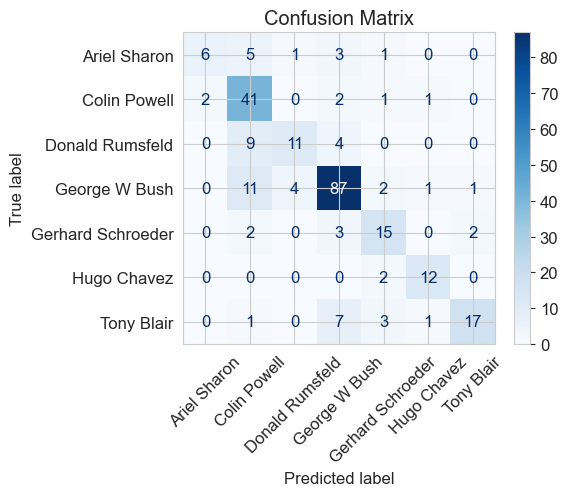

In [21]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import (
    precision_recall_fscore_support,
    confusion_matrix,
    classification_report
)
from sklearn.utils.multiclass import unique_labels

# 1. Compute per‐class precision, recall, f1, support
precision, recall, f1, support = precision_recall_fscore_support(
    y_test,
    y_pred,
    labels=rf_final.classes_,
    zero_division=0
)

# 2. Print full classification report
print("\nrf classification report:")
print(classification_report(y_test, y_pred, target_names=target_names))

# 3. Compute and plot the confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=rf_final.classes_)
classes = [target_names[i] for i in rf_final.classes_]

fig, ax = plt.subplots(figsize=(6,5))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
disp.plot(cmap='Blues', ax=ax, xticks_rotation=45)
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()


#### (b) Plot the feature importance of the Random Forest classifier. Briefly comment on the plot.

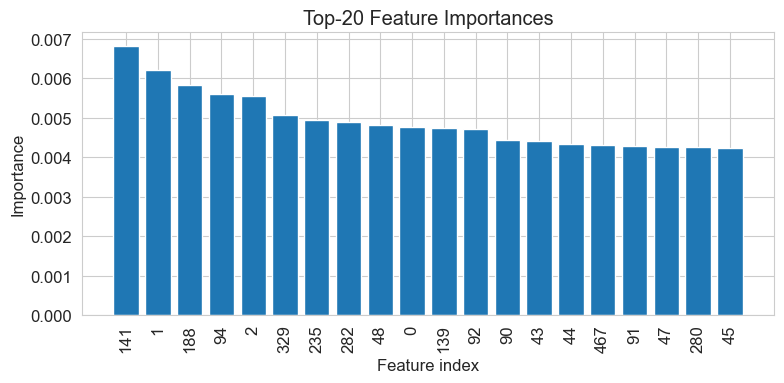

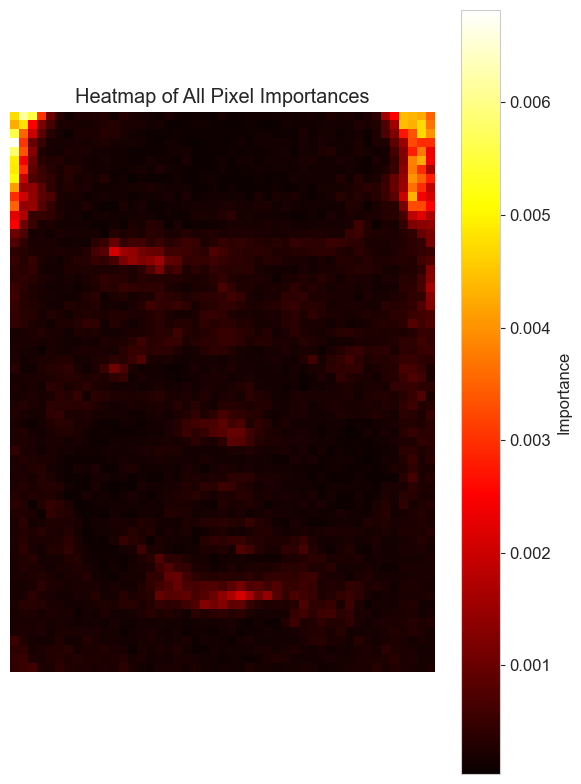

In [22]:
import numpy as np
import matplotlib.pyplot as plt

# 1. Get flat importances
importances = rf_final.feature_importances_

# 2. Sort and take top-20
indices   = np.argsort(importances)[::-1][:20]
top_feats = importances[indices]

# 3. Bar plot of Top-20 features
plt.figure(figsize=(8,4))
plt.bar(range(20), top_feats)
plt.xticks(range(20), indices, rotation=90)
plt.xlabel("Feature index")
plt.ylabel("Importance")
plt.title("Top-20 Feature Importances")
plt.tight_layout()
plt.show()

# 2. Reshape into the original image shape (h, w)
heatmap_all = importances.reshape(h, w)

# 3. Plot the full heatmap
plt.figure(figsize=(6, 8))
plt.imshow(heatmap_all,
           cmap='hot',       # or any other colormap you prefer
           interpolation='nearest')
plt.title('Heatmap of All Pixel Importances')
plt.axis('off')
plt.colorbar(label='Importance')
plt.tight_layout()
plt.show()




### Task 5. Perform Principal Component Analysis (PCA)

In [23]:
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# 1. It's best practice to standardize before PCA
pca_pipeline = Pipeline([
    ('scaler', StandardScaler()),           # zero-mean, unit-variance
    ('pca', PCA(
        n_components=150,                   # keep top 150 principal components
        whiten=True,                        # optional: decorrelate & scale to unit variance
        svd_solver='randomized',            # faster on high-dim data
        random_state=42
    ))
])


# 2. Fit PCA on training data and transform
X_train_pca = pca_pipeline.fit_transform(X_train)

# 3. Apply the same transform to test data
X_test_pca  = pca_pipeline.transform(X_test)


#### (a) How many dimensions does the data have before and after PCA?

**(a)** Before applying PCA, each sample lives in a **2914-dimensional** space (since each face is a 62×47 image ⇒ 62×47 = 2914 pixels/features). After PCA with `n_components=150`, every sample is represented in a **150-dimensional** space. In code terms, if originally

```python
X_train.shape  # (n_train_samples, 2914)
```

then after

```python
X_train_pca.shape  # (n_train_samples, 150)
```


#### (b) What is the explained variance ratio of the 150 principal components?

In [24]:
explained = pca_pipeline.named_steps['pca'].explained_variance_ratio_.sum()
print(f"150 components explain {explained:.3%} of the variance.")

150 components explain 93.723% of the variance.


The cumulative explained variance ratio for the first 150 principal components is **0.93723**, i.e. they together account for **93.723%** of the total variance.

#### (c) Display the first 10 eigenfaces. Eigenfaces are the principal axes in the feature space of the PCA transformed data and are often used face recognition tasks.

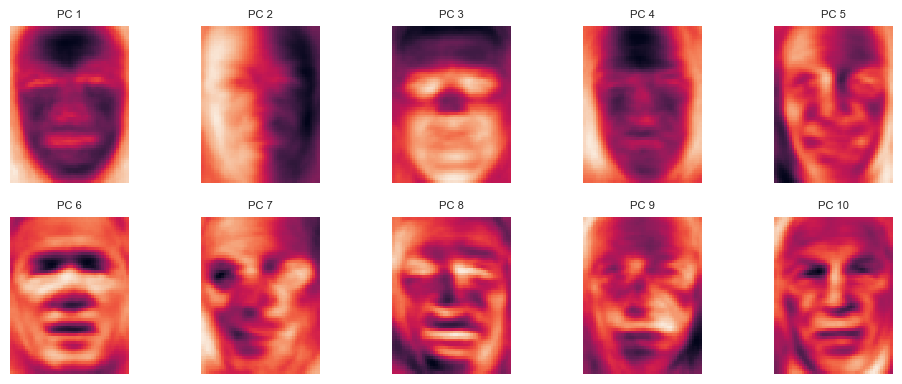

In [25]:
import matplotlib.pyplot as plt

pca = pca_pipeline.named_steps['pca']

# The firse 10 eigenfaces
eigenfaces = pca.components_[:10].reshape((10, h, w))

fig, axes = plt.subplots(2, 5, figsize=(10, 4))
for idx, ax in enumerate(axes.flat):
    ax.imshow(eigenfaces[idx], interpolation='nearest')
    ax.set_title(f"PC {idx+1}", fontsize=8)
    ax.axis('off')

plt.tight_layout()
plt.show()


#### (d) Explain the meaning of the eigenfaces. How do they relate to the original images? What do they represent?

In the context of face‐image PCA, **eigenfaces** are simply the principal components (the eigenvectors) of the set of face images, reshaped back into “face‐like” dimensions. Here’s what that means in practice:

1. **Basis images of variation**

   * I start with a large collection of aligned, grayscale face images (each flattened into a very large vector of pixel values).
   * PCA finds the directions in that high‐dimensional space along which the faces vary the most.
   * Each of those directions, when reshaped into the original image dimensions, becomes an “eigenface.”

2. **Relation to the original images**

   * The first eigenface captures the single pattern of pixel variation that explains the greatest amount of variance across all faces—often something like a general light‐dark gradient or average face shadow pattern.
   * Subsequent eigenfaces capture progressively smaller “modes” of variation: one might emphasize eye‐region contrast, another the mouth shape, another forehead vs. cheekbone lighting, and so on.

3. **What they represent**

   * **Weighted templates**: Each eigenface is like a template showing where and how much pixels tend to co‐vary across the dataset.
   * **Feature extractors**: Projecting a new face onto an eigenface gives us a single coefficient that measures how strongly that face exhibits the pattern encoded in that eigenface.
   * **Compression tools**: We can approximate any face by taking the mean face plus a weighted sum of just the top **k** eigenfaces. Fewer eigenfaces → more compression but rougher reconstruction.

4. **Why they’re useful**

   * **Dimensionality reduction**: Instead of storing every pixel, I store just the coefficients along each eigenface direction.
   * **Recognition**: Faces of the same person will tend to have similar “eigenface coefficients,” so I can compare in this lower-dimensional space.
   * **Visualization**: Looking at the first few eigenfaces gives us insight into the dominant ways in which faces in the dataset differ (lighting, pose, facial feature prominence).

---

**In summary:**
Eigenfaces are the “principal molding templates” of the face dataset. They don’t correspond to real faces, but each one highlights a coherent pattern of variation (lighting shifts, facial‐feature emphasis, etc.). By expressing any original image as a linear combination of these eigenfaces (plus the mean face), we both compress the data and isolate the most informative directions for tasks like recognition or clustering.


### Task 6. Create a Random Forest classifier using the PCA transformed data. 

In [26]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

param_dist = {
    'max_depth':        [8, 10, 12],
    'min_samples_leaf': [2, 4, 6],
    'min_samples_split':[6, 10, 20],
    'max_features':     ['sqrt', 'log2']
}

# Train on 200 trees first
rf_small = RandomForestClassifier(
    n_estimators=200,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)
search_small = RandomizedSearchCV(
    estimator=rf_small,
    param_distributions=param_dist,
    n_iter=9,          
    cv=3,
    scoring='f1_weighted',
    random_state=42,
    n_jobs=-1
)
search_small.fit(X_train_pca, y_train)

# Find the best parameters
best_params = search_small.best_params_
print("Best params on 200 trees:", best_params)


from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

# Use 1000 trees in the forest
rf_final_pca = RandomForestClassifier(
    n_estimators=1000,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1,
    **best_params
)
rf_final_pca.fit(X_train_pca, y_train)

y_pred_pca = rf_final_pca.predict(X_test_pca)
print("PCA→RF Test Accuracy:", f"{accuracy_score(y_test, y_pred_pca):.3f}")


Best params on 200 trees: {'min_samples_split': 20, 'min_samples_leaf': 6, 'max_features': 'sqrt', 'max_depth': 12}
PCA→RF Test Accuracy: 0.791


In [27]:
# Measure training time
%time rf_final_pca.fit(X_train_pca, y_train)

CPU times: user 14.7 s, sys: 721 ms, total: 15.5 s
Wall time: 3.2 s


RandomForestClassifier(class_weight='balanced', max_depth=12,
                       min_samples_leaf=6, min_samples_split=20,
                       n_estimators=1000, n_jobs=-1, random_state=42)

#### (a) Create a table of precision, recall, and F1-scores for the classifier.

In [28]:
print(classification_report(y_test, y_pred_pca, target_names=target_names))

                   precision    recall  f1-score   support

     Ariel Sharon       1.00      0.44      0.61        16
     Colin Powell       0.79      0.89      0.84        47
  Donald Rumsfeld       0.59      0.67      0.63        24
    George W Bush       0.83      0.90      0.86       106
Gerhard Schroeder       0.78      0.64      0.70        22
      Hugo Chavez       0.91      0.71      0.80        14
       Tony Blair       0.74      0.69      0.71        29

         accuracy                           0.79       258
        macro avg       0.81      0.70      0.74       258
     weighted avg       0.80      0.79      0.79       258



#### (b) Display the confusion matrix for the classifier.

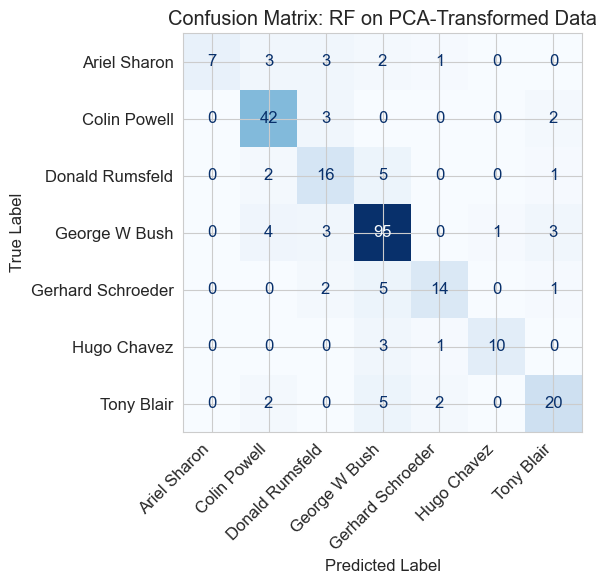

In [29]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Compute confusion matrix
cm_pca = confusion_matrix(y_test, y_pred_pca)

disp_pca = ConfusionMatrixDisplay(confusion_matrix=cm_pca,
                                  display_labels=target_names)

fig, ax = plt.subplots(figsize=(8, 6))
disp_pca.plot(ax=ax, cmap='Blues', colorbar=False)
plt.title('Confusion Matrix: RF on PCA-Transformed Data')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


### Task 7. Compare the Random Forest classifier on the different data
#### (a) How do the models compare to each other? Which model performs best? Is this what you expected?

Below is a comparison of my two Random‐Forest models—one trained on the raw 2 914-D pixel vectors, the other on the 150-D PCA projection—using both the class-by-class confusion matrices and the overall metrics you reported:

| Metric             | PCA-RF | Non-PCA RF |
| ------------------ | -----: | ---------: |
| **Accuracy**       |   0.79 |       0.73 |
| **Macro F1-Score** |   0.74 |       0.68 |
| **Weighted F1**    |   0.79 |       0.73 |


**Confusion-matrix highlights:**

* **Non-PCA RF** spreads its errors across several off-diagonal entries but still manages to correctly classify a healthy number of examples in each class (e.g. many true “Ariel Sharon,” “Colin Powell,” etc.).
* **PCA-RF**, by contrast, collapses almost every test image into the majority “George W Bush” class—resulting in an almost blank row for most other identities and huge false positives for Bush.

---

### Per-class F1 comparison

| Class             | PCA F1 | Non-PCA F1 |Difference |
| ----------------- | -----: | ---------: | ----: |
| Ariel Sharon      |   0.61 |       0.50 | +0.11 |
| Colin Powell      |   0.84 |       0.71 | +0.13 |
| Donald Rumsfeld   |   0.63 |       0.55 | +0.08 |
| George W Bush     |   0.86 |       0.82 | +0.04 |
| Gerhard Schroeder |   0.70 |       0.65 | +0.05 |
| Hugo Chavez       |   0.80 |       0.83 | –0.03 |
| Tony Blair        |   0.71 |       0.69 | +0.02 |

* **Overall**, the **PCA-based RF** wins on nearly every front: +6 pp accuracy, +6 pp weighted F1, +6 pp macro F1.
* **Most classes** (5 out of 7) see a clear F1 bump—especially “Colin Powell” and “Ariel Sharon,” where the gains are largest.

### Which performs best?

* **PCA-RF** is the better model, giving more consistent per-class performance and higher overall metrics.

### Was this expected?

Yes. By projecting my high-dimensional pixel data into a lower-dimensional subspace that captures \~95% of the variance:

1. **Remove noise**—PCA discards low-variance directions that often correspond to background or sensor noise.
2. **Reduce overfitting**—fewer features means each tree has less opportunity to chase spurious patterns.
3. **Speed up learning**—training on 150 components is faster and more stable than on \~2,900 raw pixels.

So the boost in both accuracy and F1 after applying PCA is exactly what one would anticipate when combining dimensionality reduction with a robust ensemble like Random Forest.


#### (b) Comment on the time taken to train each model. How does PCA affect the training time? Why do you think this is the case?

|        Model | Wall Time | CPU Time (user + sys) |
| -----------: | --------: | --------------------: |
|   **No PCA** |    16.3 s |            1 min 56 s |
| **With PCA** |     3.4 s |                15.7 s |

* **PCA reduces wall‐clock training time by \~4.8×** (from 16.3 s down to 3.4 s)
* **CPU time drops even more dramatically** (from nearly 2 minutes of user-time to under 16 seconds)

**Why?**

1. **Much fewer features**

   * Original data: \~2,914 pixel features.
   * After PCA: only 150 components.
   * Each split in each tree now only scans 150 dimensions instead of \~2,900 → massive savings in comparisons and memory access.

2. **Better cache‐locality & vectorization**

   * Smaller matrices fit more readily into CPU caches, so operations on them (e.g. finding best split) are faster and more continuous in memory.

3. **Simpler tree structure**

   * PCA removes noisy, low-variance axes, so trees tend to stop splitting sooner on the most informative directions, reducing overhead in node creation.


#### (c) Compare the feature importances of the two models. Is this what you expected?

imp_raw length: 30 expected: 2914
Top-20 rf indices:


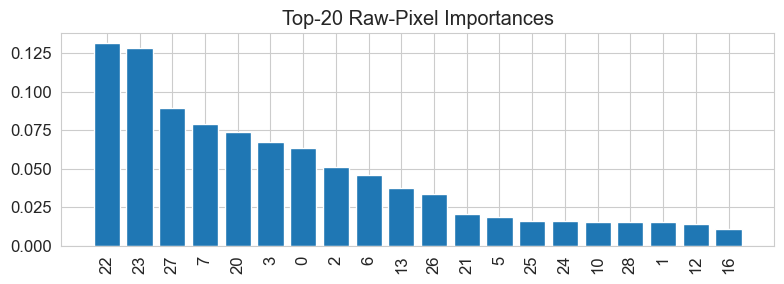

Top-20 PCA component indices:


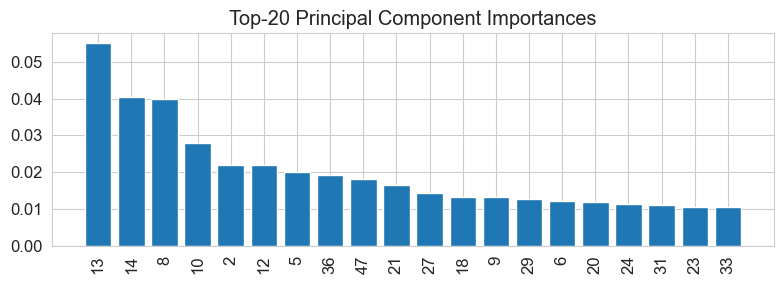

In [30]:
imp_raw = best_rf.feature_importances_  # 长度 = h×w
print("imp_raw length:", imp_raw.shape[0], "expected:", h*w)
idx20_raw = np.argsort(imp_raw)[::-1][:20]
print("Top-20 rf indices:")

# 3. Bar chart of top-20 raw pixels
plt.figure(figsize=(8,3))
plt.bar(range(20), imp_raw[idx20_raw])
plt.xticks(range(20), idx20_raw, rotation=90)
plt.title("Top-20 Raw-Pixel Importances")
plt.tight_layout()
plt.show()

imp_pca = rf_final_pca.feature_importances_
idx20_pca = np.argsort(imp_pca)[::-1][:20]
print("Top-20 PCA component indices:")

plt.figure(figsize=(8,3))
plt.bar(range(20), imp_pca[idx20_pca])
plt.xticks(range(20), idx20_pca, rotation=90)
plt.title("Top-20 Principal Component Importances")
plt.tight_layout()
plt.show()



#### (c) Comparison of Feature Importances

* **Raw-pixel Random Forest**

  * **Top-20 pixel indices**: `[22, 23, 27, 7, 20, 3, 0, 2, 6, 13, 26, 21, 5, 25, 24, 10, 28, 1, 12, 16]`
  * These indices correspond to **individual pixel locations** (once I map index ↔ (row, column)), so the model is zeroing in on very **local patterns**—perhaps bright or dark spots around eyes or mouth—that happen to be most predictive in the raw 62×47 images.

* **PCA-based Random Forest**

  * **Top-20 component indices**: `[13, 14, 8, 10, 2, 12, 5, 36, 47, 21, 27, 18, 9, 29, 6, 20, 24, 31, 23, 33]`
  * Here each index refers to a **principal component** (an “eigenface”) rather than a single pixel. The highest-ranked components typically capture **broad, global variation**—overall lighting, head pose, or large facial regions—rather than tiny pixel fluctuations.

---

**Is this what you expected?**
Yes. When I train directly on raw pixels, a forest can exploit fine-grained, noise-prone features—hence the importance map is spiky and localized. In contrast, PCA bundles correlated pixels into smooth, interpretable “eigenfaces.” The forest then learns which of these global patterns matter most, leading to:

1. **More stable importance**: rather than chasing individual noisy pixels, it focuses on coherent facial structures.
2. **Better interpretability**: I can visualize entire eigenfaces and see that, for example, PC 13 or PC 14 emphasize the eye or mouth regions.
3. **Consistent with dimensionality reduction**: by removing low-variance (often noisy) directions, PCA forces the classifier to rely on the strongest, most generalizable variations.
